
# Readme
## Introduction
Here is our code for the paper "An Interactive Insight Identification and Annotation Framework for Power Grid Pixel Maps using DenseU-Hierarchical VAE". We open source the dataset we use (from the North China Power Grid), the specific details of DUHiV, and the trained network parameters. We also give the operation of latent variable inference and spatial transformation and interpolation of latent variables with some examples.

**You can run each block and look at the result of demo first**

## Package Requirement
```
torch
collections
numpy
os
math
cv2
pickle
matplotlib
glob
```

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import numpy as np
import torch.utils.checkpoint as cp
import os
import math
import cv2
from os import path
import pickle
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from pylab import subplots_adjust
from glob import glob

## The specific details of DUHiV
Following is the code of DUHiV, and class DenseUnetHiearachicalVAE is the main function of DUHiV with 2 latent layers and each has 8 latent variables.

In [2]:
def _bn_function_factory(norm, relu, conv):
    def bn_function(*inputs):
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = conv(relu(norm(concated_features)))
        return bottleneck_output

    return bn_function


class _PreProcess(nn.Sequential):
    def __init__(self, num_input_channels, num_init_features):
        super(_PreProcess, self).__init__()
        self.add_module('conv0',
                        nn.Conv2d(num_input_channels, num_init_features, kernel_size=7, stride=2, padding=3,
                                  bias=False))
        self.add_module('norm0', nn.BatchNorm2d(num_init_features))
        self.add_module('relu0', nn.ReLU(inplace=True))
        self.add_module('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1,
                                              ceil_mode=False))


class _DenseLayer2D(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, efficient=False):
        super(_DenseLayer2D, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1, bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1, bias=False)),
        self.drop_rate = drop_rate
        self.efficient = efficient

    def forward(self, *prev_features):
        bn_function = _bn_function_factory(self.norm1, self.relu1, self.conv1)
        if self.efficient and any(prev_feature.requires_grad for prev_feature in prev_features):
            bottleneck_output = cp.checkpoint(bn_function, *prev_features)
        else:
            bottleneck_output = bn_function(*prev_features)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return new_features


class _Transition2D(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition2D, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class _DenseBlock2D(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, efficient=False):
        super(_DenseBlock2D, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer2D(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                efficient=efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.named_children():
            new_features = layer(*features)
            features.append(new_features)
        return torch.cat(features, 1)


class DenseNet2d(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 3 or 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
            (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        small_inputs (bool) - set to True if images are 32x32. Otherwise assumes images are larger.
        efficient (bool) - set to True to use checkpointing. Much more memory efficient, but slower.
    """

    def __init__(self, num_input_channels=1, growth_rate=12, block_config=(6, 12, 24, 16), compression=0.5,
                 num_init_features=24, bn_size=4, drop_rate=float(0), efficient=False):

        super(DenseNet2d, self).__init__()
        assert 0 < compression <= 1, 'compression of densenet should be between 0 and 1'
        # First convolution
        self.encoder = nn.Sequential()
        pre_process = _PreProcess(num_input_channels, num_init_features)
        self.encoder.add_module("pre_process", pre_process)
        assert 0 < compression <= 1, 'compression of densenet should be between 0 and 1'
        # add dense block
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock2D(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                efficient=efficient,
            )
            self.encoder.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition2D(num_input_features=num_features,
                                      num_output_features=int(num_features * compression))
                self.encoder.add_module('transition%d' % (i + 1), trans)
                num_features = int(num_features * compression)
            else:
                trans = nn.BatchNorm2d(num_features)
                self.encoder.add_module('transition%d' % (i + 1), trans)

        # Initialization (by xavier)
        for name, param in self.named_parameters():
            if 'conv' in name and 'weight' in name:
                # N_in = param.size(0)*kernel_size
                # N_out= param.size(1)*kernel_size
                # variance = 1/N = 1/(N_in + N_out)/2 = 2/(N_in +N_out)
                nn.init.xavier_normal_(param.data)
            elif 'norm' in name and 'weight' in name:
                param.data.fill_(1)
            elif 'norm' in name and 'bias' in name:
                param.data.fill_(0)

    def forward(self, x):
        encoding_features = self.encoder(x)
        return encoding_features
class _DecoderBlock2D(nn.Sequential):
    def __init__(self, num_input_features, num_output_features, drop_rate=float(0)):
        super(_DecoderBlock2D, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU())
        self.add_module("conv", nn.Conv2d(num_input_features, out_channels=num_output_features,
                                          kernel_size=3, stride=1, padding=1, bias=False))
        self.add_module("drop", nn.Dropout2d(p=drop_rate))


class _PreProcess(nn.Sequential):
    def __init__(self, num_input_channels, num_init_features):
        super(_PreProcess, self).__init__()
        self.add_module('conv0',
                        nn.Conv2d(num_input_channels, num_init_features, kernel_size=7, stride=2, padding=2,
                                  bias=False))
        """
        self.add_module('conv0',nn.Conv2d(num_input_channels, num_init_features, kernel_size=7, stride=2, padding=3,
                                  bias=False))
        Here we change from padding = 3 to padding =2 to match the image size
        """
        self.add_module('norm0', nn.BatchNorm2d(num_init_features))
        self.add_module('relu0', nn.ReLU(inplace=True))
        self.add_module('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1,
                                              ceil_mode=False))


class _FinalProcess(nn.Sequential):
    def __init__(self, num_input_channels, num_init_features, num_feature_channels):
        super(_FinalProcess, self).__init__()
        self.add_module("final_norm0", nn.BatchNorm2d(num_feature_channels))
        self.add_module("final_relu0", nn.ReLU())
        self.add_module('final_conv0', nn.Conv2d(num_feature_channels, out_channels=num_init_features,
                                                 kernel_size=3, stride=1, padding=1, bias=False))
        self.add_module("final_deconv0", nn.ConvTranspose2d(num_init_features, out_channels=num_init_features,
                                                            kernel_size=2, stride=2, padding=0, bias=False))
        self.add_module("final_norm1", nn.BatchNorm2d(num_init_features))
        self.add_module("final_relu1", nn.ReLU())
        self.add_module('final_conv1', nn.Conv2d(num_init_features, out_channels=num_input_channels,
                                                 kernel_size=3, stride=1, padding=1, bias=False))
        self.add_module("final_deconv1", nn.ConvTranspose2d(num_input_channels, out_channels=num_input_channels,
                                                            kernel_size=2, stride=2, padding=0, bias=True))


class _LatentVariableInference2d(nn.Module):
    def __init__(self, input_size, latent_dim, num_input_channels, num_output_channels):
        super(_LatentVariableInference2d, self).__init__()
        self.input_size = input_size
        self.num_input_channels = num_input_channels
        self.num_output_channels = num_output_channels
        self.z_mean_map = nn.Linear(int(num_input_channels * input_size[0] * input_size[1]), latent_dim)
        self.z_log_sigma_map = nn.Linear(int(num_input_channels * input_size[0] * input_size[1]), latent_dim)
        self.z_decoder_map = nn.Linear(latent_dim, int(num_output_channels * input_size[0] * input_size[1]))

    def _inference(self, features):
        mu = self.z_mean_map(features)
        log_sigma = self.z_log_sigma_map(features)
        sigma = torch.exp(log_sigma)
        self.z_mean = mu
        self.z_sigma = sigma
        self.z_log_sigma = log_sigma
        return mu, log_sigma, sigma

    def _sample_latent(self, features):
        """
        Return the latent normal sample z ~ N(mu, sigma^2)
        """
        mu, log_sigma, sigma = self._inference(features)
        std_z = torch.randn(sigma.size())
        if features.is_cuda:
            std_z = std_z.cuda()
        return mu + sigma * std_z

    def decode_latent_variable(self, z):
        decode_features = self.z_decoder_map(z)
        decode_features = decode_features.view(z.size(0), self.num_output_channels, int(self.input_size[0]),
                                               int(self.input_size[1]))
        return decode_features

    def forward(self, features):
        batch_size = features.size(0)
        features = features.view(batch_size, -1)
        z = self._sample_latent(features)
        decode_features = self.decode_latent_variable(z)
        return decode_features, self.z_mean, self.z_sigma, self.z_log_sigma


class DenseUnetHiearachicalVAE(nn.Module):
    def __init__(self, num_input_channels=1, growth_rate=12, block_config=[6, 12, 24, 16], compression=0.5,
                 num_init_features=24, bn_size=4, drop_rate=float(0), efficient=False,
                 latent_dim=[16, 16], img_size=[128, 128], data_parallel=True):
        """
        :param num_input_channels: the channel of images to imput
        :param growth_rate: the middle feature for dense block
        :param block_config: the config for block
        :param compression: the compression rate after each dense block
        :param num_init_features:the initialize feature sending to the dense net
        :param bn_size: dense layer's structure is 1*1 and 3*3, bn_size * growth_rate is the middle feature channel
        :param drop_rate: the drop rate for network
        :param efficient: True we use checkpoints for dense layer, false no checkpoints
        """
        super(DenseUnetHiearachicalVAE, self).__init__()
        self.block_config = block_config
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential()
        self.inference = nn.Sequential()
        self.img_size = tuple(img_size)
        pre_process = _PreProcess(num_input_channels, num_init_features)
        if data_parallel:
            pre_process = nn.DataParallel(pre_process)
        self.encoder.add_module("pre_process", pre_process)
        # img_size = [s / 2 for s in img_size]
        img_size = [s / 4 for s in img_size]
        assert 0 < compression <= 1, 'compression of densenet should be between 0 and 1'
        # add dense block
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock2D(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                efficient=efficient,
            )
            if data_parallel:
                block = nn.DataParallel(block)
            self.encoder.add_module('denseblock%d' % (i + 1), block)
            num_features = int(num_features + num_layers * growth_rate)
            # Here we notice that for the last dense block, we don't apply transition layer
            if i != len(block_config) - 1:
                trans = _Transition2D(num_input_features=num_features,
                                      num_output_features=int(num_features * compression))
                if data_parallel:
                    trans = nn.DataParallel(trans)
                self.encoder.add_module('transition%d' % (i + 1), trans)
                num_features = int(num_features * compression)
                img_size = [int(s / 2) for s in img_size]
                # here we should make sure how many latent layers we use
                if i >= len(block_config) - len(latent_dim):
                    inference = _LatentVariableInference2d(input_size=img_size,
                                                           latent_dim=latent_dim[i - len(block_config)],
                                                           num_input_channels=num_features,
                                                           num_output_channels=num_features)
                    if data_parallel:
                        inference = nn.DataParallel(inference)
                    self.inference.add_module('latent_layer%d' % (i + 1), inference)

            else:
                trans = nn.BatchNorm2d(num_features)
                if data_parallel:
                    trans = nn.DataParallel(trans)
                self.encoder.add_module('transition%d' % (i + 1), trans)
                inference = _LatentVariableInference2d(input_size=img_size,
                                                       latent_dim=latent_dim[i - len(block_config)],
                                                       num_input_channels=num_features,
                                                       num_output_channels=num_features)
                if data_parallel:
                    inference = nn.DataParallel(inference)
                self.inference.add_module('latent_layer%d' % (i + 1), inference)

        self.decoder_channel_list = self.calculate_channel_number(num_init_features, block_config, growth_rate,
                                                                  compression)
        self.decoder = nn.Sequential(OrderedDict([]))
        for i in range(len(self.decoder_channel_list) - 1, 0, -1):
            decoder_block = _DecoderBlock2D(self.decoder_channel_list[i], self.decoder_channel_list[i - 1],
                                            drop_rate)
            decoder_deconv = nn.ConvTranspose2d(int(self.decoder_channel_list[i - 1]),
                                                out_channels=self.decoder_channel_list[i - 1],
                                                kernel_size=2, stride=2, padding=0, bias=False)
            if data_parallel:
                decoder_block = nn.DataParallel(decoder_block)
                decoder_deconv = nn.DataParallel(decoder_deconv)
            self.decoder.add_module("decoder_block%d" % (i + 1), decoder_block)
            self.decoder.add_module("decoder_block%d_deconv" % (i + 1), decoder_deconv)
        final_process = _FinalProcess(num_input_channels=num_input_channels,
                                      num_init_features=num_init_features,
                                      num_feature_channels=self.decoder_channel_list[0])
        if data_parallel:
            final_process = nn.DataParallel(final_process)
        self.decoder.add_module("final_process", final_process)
        for name, param in self.named_parameters():
            if 'conv' in name and 'weight' in name:
                nn.init.xavier_normal_(param.data)
            # initialize liner transform
            elif 'map' in name and 'weight' in name:
                nn.init.xavier_normal_(param.data)
            elif 'map' in name and 'bias' in name:
                param.data.fill_(0)
            # initialize the batch norm layer
            elif 'norm' in name and 'weight' in name:
                param.data.fill_(1)
            elif 'norm' in name and 'bias' in name:
                param.data.fill_(0)

    def forward(self, input_img):
        output = self.encoder.pre_process(input_img)
        inference_feature_list = []
        latent_variable_mean_list = []
        latent_variable_sigma_list = []
        latent_variable_log_sigma_list = []
        for i in range(len(self.block_config)):
            output = getattr(self.encoder, "denseblock%d" % (i + 1))(output)
            output = getattr(self.encoder, "transition%d" % (i + 1))(output)
            if i >= len(self.block_config) - len(self.latent_dim):
                inference_feature, z_mean, z_sigma, z_log_sigma = getattr(self.inference, "latent_layer%d" % (i + 1))(
                    output)
                inference_feature_list.append(inference_feature)
                latent_variable_mean_list.append(z_mean)
                latent_variable_sigma_list.append(z_sigma)
                latent_variable_log_sigma_list.append(z_log_sigma)
        for i in range(len(self.decoder_channel_list), 1, -1):
            if i == len(self.decoder_channel_list):
                output = getattr(self.decoder, "decoder_block%d" % i)(
                    inference_feature_list[i - 1 - len(self.decoder_channel_list)])
                if len(self.decoder_channel_list) + 2 - i <= len(self.latent_dim):
                    output += inference_feature_list[i - 2 - len(self.decoder_channel_list)]
                output = getattr(self.decoder, "decoder_block%d_deconv" % i)(output)
            else:
                output = getattr(self.decoder, "decoder_block%d" % i)(output)
                if len(self.decoder_channel_list) + 2 - i <= len(self.latent_dim):
                    output += inference_feature_list[i - 2 - len(self.decoder_channel_list)]
                output = getattr(self.decoder, "decoder_block%d_deconv" % i)(output)
        output = self.decoder.final_process(output)
        output = torch.sigmoid(F.interpolate(output, size=self.img_size, mode='bilinear', align_corners=True))
        return output, latent_variable_mean_list, latent_variable_sigma_list, latent_variable_log_sigma_list

    def generate_from_raw_img(self, input_img, generate_times=1):
        """
        :param input_img: 1*channel*h*w
        :param generate_times:time to generate the reconstruct images
        :return: generate img with size generate_times * channel * h * w
        """
        with torch.no_grad():
            repeat_img = input_img.repeat(generate_times, 1, 1, 1)
            reconstruct_img, latent_variable_mean_list, latent_variable_sigma_list, latent_variable_log_sigma_list = self.forward(
                repeat_img)
        return reconstruct_img, latent_variable_mean_list, latent_variable_sigma_list, latent_variable_log_sigma_list

    def generate_from_latent_variable(self, z_list):
        """
        :param z_list: a list to store the sampled hierarchical z variable,example:
        [latent_layer_1_z,latent_layer_2_z,...,latent_layer_L,z ]
        the size of latent_layer_i_z is batch_size * latent_dim
        :return: batch_size * img_size reconstructed images
        """
        with torch.no_grad():
            if len(z_list) != len(self.latent_dim):
                raise ValueError("The hierarchical number of latent dim is not equal to z_list")
            inference_feature_list = []
            for i, z in enumerate(z_list):
                inference_feature = getattr(self.inference, "latent_layer%d" % (
                        i + 1 + len(self.block_config) - len(self.latent_dim))).module.decode_latent_variable(z)
                inference_feature_list.append(inference_feature)
            for i in range(len(self.decoder_channel_list), 1, -1):
                if i == len(self.decoder_channel_list):
                    output = getattr(self.decoder, "decoder_block%d" % i)(
                        inference_feature_list[i - 1 - len(self.decoder_channel_list)])
                    if len(self.decoder_channel_list) + 2 - i <= len(self.latent_dim):
                        output += inference_feature_list[i - 2 - len(self.decoder_channel_list)]
                    output = getattr(self.decoder, "decoder_block%d_deconv" % i)(output)
                else:
                    output = getattr(self.decoder, "decoder_block%d" % i)(output)
                    if len(self.decoder_channel_list) + 2 - i <= len(self.latent_dim):
                        output += inference_feature_list[i - 2 - len(self.decoder_channel_list)]
                    output = getattr(self.decoder, "decoder_block%d_deconv" % i)(output)
            output = self.decoder.final_process(output)
            output = torch.sigmoid(F.interpolate(output, size=self.img_size, mode='bilinear', align_corners=True))
        return output

    @staticmethod
    def calculate_channel_number(init_number, block_config, growth_rate, compression, final_compression_flag=False):
        """
        :param init_number: the init channel number for dense encoder
        :param block_config: the dense block layer config for dense encoder
        :param growth_rate: the growth rate for dense layer
        :param compression: the compression rate (default :0.5)
        :param final_compression_flag: if true, then after final dense block, we will do bn,relu conv and maxpooling,
        which means we will do channel compress (in conv operation). if false, then we only do bn
        :return: channel_number_list
        """
        channel = init_number
        channel_number_list = []
        for i, layer_num in enumerate(block_config):
            channel += growth_rate * layer_num
            if i != len(block_config) - 1:
                channel *= compression
            else:
                if final_compression_flag:
                    channel *= compression
            channel_number_list.append(int(channel))
        return channel_number_list

## Parameter loading and the functions of inference, value change and interpolation

In [55]:
class DUHiVFunctions(DenseUnetHiearachicalVAE):
    def __init__(self, resume_path,inference_result_path, device_id="0,1", gpu_flag=True):
        os.environ['CUDA_VISIBLE_DEVICES'] = device_id
        """
        :param resume_path: the resume path for network parameter
        :param inference_result_path: the path store the inferenced result
        :param device_id: we need GPUs for calculation, and device id the id of GPU we want to use
        """
        if os.path.isfile(resume_path):
            checkpoint = torch.load(resume_path)
        else:
            raise FileNotFoundError("{} not found".format(resume_path))
        args = checkpoint['args']
        self.latent_dim = args.latent_dim
        super(DUHiVFunctions, self).__init__(num_input_channels=1, latent_dim=args.latent_dim,
                                                                data_parallel=args.data_parallel,
                                                                img_size=args.image_size,
                                                                block_config=args.block_config,
                                                                growth_rate=args.growth_rate)
        # do data parallel
        self.load_state_dict(checkpoint["state_dict"])
        if gpu_flag:
            self.cuda()
        self.gpu_flag = gpu_flag
        self.eval()
        with open(path.join(inference_result_path,"train.pkl"),"rb") as f:
            self.train_inference_dict = pickle.load(f) 
        with open(path.join(inference_result_path,"valid.pkl"),"rb") as f:
            self.valid_inference_dict = pickle.load(f) 
        
    def get_inference_by_image(self,input_image):
        """
        :param input_image should be an batch_size*channel*h*w numpy array
        :return: return mean with [layer1_mean,layer2_mean,layer3_mean], log_sigma with
        [layer1_log_sigma,layer2_log_sigma,layer3_log_sigma],all items in list is an numpy array
        with batch_size * latent_dim
        """
        input_image = torch.from_numpy(input_image).float()
        if self.gpu_flag:
            input_image = input_image.cuda()
        output, latent_variable_mean_list, latent_variable_sigma_list, latent_variable_log_sigma_list = self.forward(input_image)
        mean_list = []
        log_sigma_list = []
        for mean_tensor in latent_variable_mean_list:
            mean_list.append(mean_tensor.cpu().detach().numpy())
        for log_sigma_tensor in latent_variable_log_sigma_list:
            log_sigma_list.append(log_sigma_tensor.cpu().detach().numpy())
        return mean_list,log_sigma_list

    def get_image_from_original_to_target(self, original, target, split_number, sample_number):
        """
        :param original: the original distribution's parameters e.g.{mu:npy,log_sigma:npy}
        :param target: the target distribution's parameters e.g.{mu:npy,log_sigma:npy}
        :param split_number: the number we should split t=[0,1] in
        :param sample_number: how many items should we sample for each distribution P_t
        :return: numpy array with split_number*sample_number*h*w
        """
        mu_original = original["mu"]
        sigma_original = np.exp(original["log_sigma"])
        mu_target = target["mu"]
        sigma_target = np.exp(target["log_sigma"])
        latent_dim = mu_original.shape[1]
        t_split = np.linspace(0, 1, split_number + 2)[1:split_number + 1].reshape(split_number, 1)
        mu_t = (1 - t_split) * mu_original + t_split * mu_target
        sigma_t = (1 - t_split) * sigma_original + t_split * sigma_target

        norm_sample = np.random.normal(0, 1, size=(sample_number, latent_dim))
        # use the broad cast trick
        z_sample = mu_t.reshape(split_number, 1, latent_dim) + norm_sample.reshape(1, sample_number,
                                                                                   latent_dim) * sigma_t.reshape(
            split_number, 1, latent_dim)
        z_sample = z_sample.reshape(-1, latent_dim)
        reconstruct = self.get_image_by_sample(z_sample)
        reconstruct = reconstruct.reshape(split_number, sample_number, reconstruct.shape[1],
                                          reconstruct.shape[2])
        return reconstruct

    def get_image_change_by_one_bar(self, original_z, latent_variable_index, bar_min, bar_max, split_number):
        """
        :param original_z: the original z sample,latent-dim array
        :param latent_variable_index: the index of latent_variable we want to change
        :param bar_min: the min value of bar
        :param bar_max: the maximum value of bar
        :param split_number: the number we want to split the bar in
        :return: numpy array with split_number * h * w
        """
        z_input = np.repeat(original_z, split_number, axis=0)
        split_array = np.linspace(bar_min, bar_max, split_number)
        z_input[:, latent_variable_index] = split_array
        # here z_input is an n*split_number size's latent variable
        reconstruct = self.get_image_by_sample(z_input)
        return reconstruct

    def get_image_by_sample(self, z_sample):
        z_sample = torch.from_numpy(z_sample).float()
        if self.gpu_flag:
            z_sample = z_sample.cuda()
        z_sample_list = self._split_sample_into_hierarchical_list(z_sample)
        reconstruct = self.generate_from_latent_variable(z_sample_list)
        batch_size = reconstruct.size(0)
        reconstruct = reconstruct.squeeze()
        if batch_size == 1:
            reconstruct = reconstruct.unsqueeze(0)
        return reconstruct.cpu().detach().numpy()
        
    
    def _split_sample_into_hierarchical_list(self, z_sample):
        z_sample_list = []
        initial_position = 0
        for i in range(len(self.latent_dim)):
            z_sample_list.append(z_sample[:, initial_position:initial_position + self.latent_dim[i]])
            initial_position += self.latent_dim[i]
        return z_sample_list

## Demo

In [8]:
duhiv_functions = DUHiVFunctions(device_id="3",resume_path="./model_parameter/checkpoint.pth.tar",inference_result_path="./model_inference")

In [9]:
image_path_list = glob("./dataset/*.png")

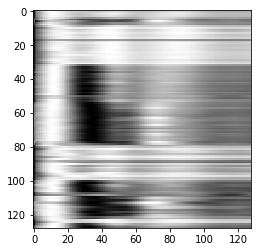

In [11]:
image = cv2.imread(image_path_list[12],0)
plt.imshow(image,cmap="gray")
plt.show()

### Demo for inference the distribution of latent variables

In [36]:
image_array = np.expand_dims(np.expand_dims((image-255)/255,0),0)
image_cuda = torch.from_numpy(image_array).float().cuda()
mean_list,log_sigma_list= duhiv_functions.get_inference_by_image(image_array)

In [16]:
mean_list

[array([[-0.04574516,  0.07308528, -0.36045375,  0.03741726, -0.36097664,
          0.16212146, -0.11041117,  0.14780125]], dtype=float32),
 array([[-0.45671496, -1.2122513 ,  0.74832726,  0.15266892, -0.04350749,
          0.4381223 , -1.2968793 ,  0.80994076]], dtype=float32)]

In [17]:
log_sigma_list

[array([[-0.23542364, -0.15734622, -0.1096693 , -0.12251923, -0.33654547,
         -0.21974514, -0.43299156, -0.2582883 ]], dtype=float32),
 array([[-2.0331407, -2.1808672, -1.3906751, -1.4911857, -1.966654 ,
         -2.1103456, -1.9828008, -1.9370726]], dtype=float32)]

### Demo for reconstruct from the inferenced distribution

In [37]:
mean = np.concatenate(mean_list,axis = 1)
sigma = np.exp(np.concatenate(log_sigma_list,axis=1))

In [20]:
z_sample = mean + np.random.randn(16)*sigma

In [22]:
reconstruct_image = duhiv_functions.get_image_by_sample(z_sample)

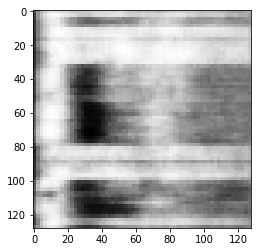

In [24]:
plt.imshow(reconstruct_image[0,...],cmap="gray")
plt.show()

### Demo for change one latent variable and see the related change in image space
Here we change the 2th latent variable in 2nd latent layer, the mean is -1.2, so we change from -5.2 to 3.2, and see the 5 reconstruction results

In [30]:
variable_change_reconstruct = duhiv_functions.get_image_change_by_one_bar(original_z=z_sample,latent_variable_index=9,bar_min=-5.2,bar_max= 3.2,split_number=5)

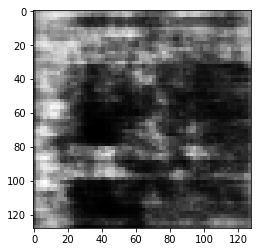

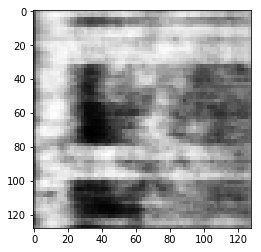

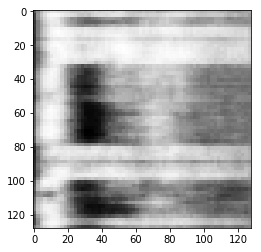

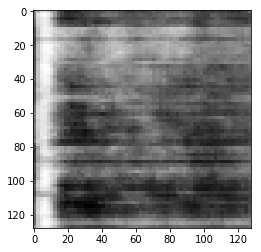

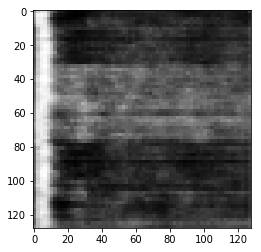

In [31]:
for i in range(5):
    plt.imshow(variable_change_reconstruct[i,...],cmap="gray")
    plt.show()

### Demo for interpolation from one image to another
Here we select 2 image and see how to create continuous change from one image to another with wasserstein distance

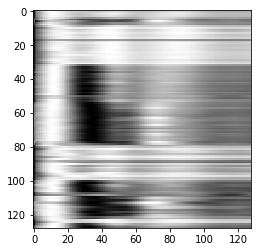

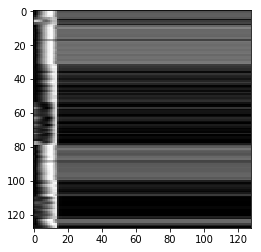

In [35]:
image1 = cv2.imread(image_path_list[12],0)
plt.imshow(image1,cmap="gray")
plt.show()
image2 = cv2.imread(image_path_list[3],0)
plt.imshow(image2,cmap="gray")
plt.show()

In [41]:
image1_array = np.expand_dims(np.expand_dims((image1-255)/255,0),0)
image1_cuda = torch.from_numpy(image1_array).float().cuda()
mean_list,log_sigma_list= duhiv_functions.get_inference_by_image(image1_array)
mean1 = np.concatenate(mean_list,axis = 1)
log_sigma1 = np.concatenate(log_sigma_list,axis=1)
image2_array = np.expand_dims(np.expand_dims((image2-255)/255,0),0)
image2_cuda = torch.from_numpy(image2_array).float().cuda()
mean_list,log_sigma_list= duhiv_functions.get_inference_by_image(image2_array)
mean2 = np.concatenate(mean_list,axis = 1)
log_sigma2 = np.concatenate(log_sigma_list,axis=1)
original = {"mu":mean1,"log_sigma":log_sigma1}
target = {"mu":mean2,"log_sigma":log_sigma2}

In [44]:
interpolation_reconstruct = duhiv_functions.get_image_from_original_to_target(original=original,target=target,sample_number=1,split_number=9)

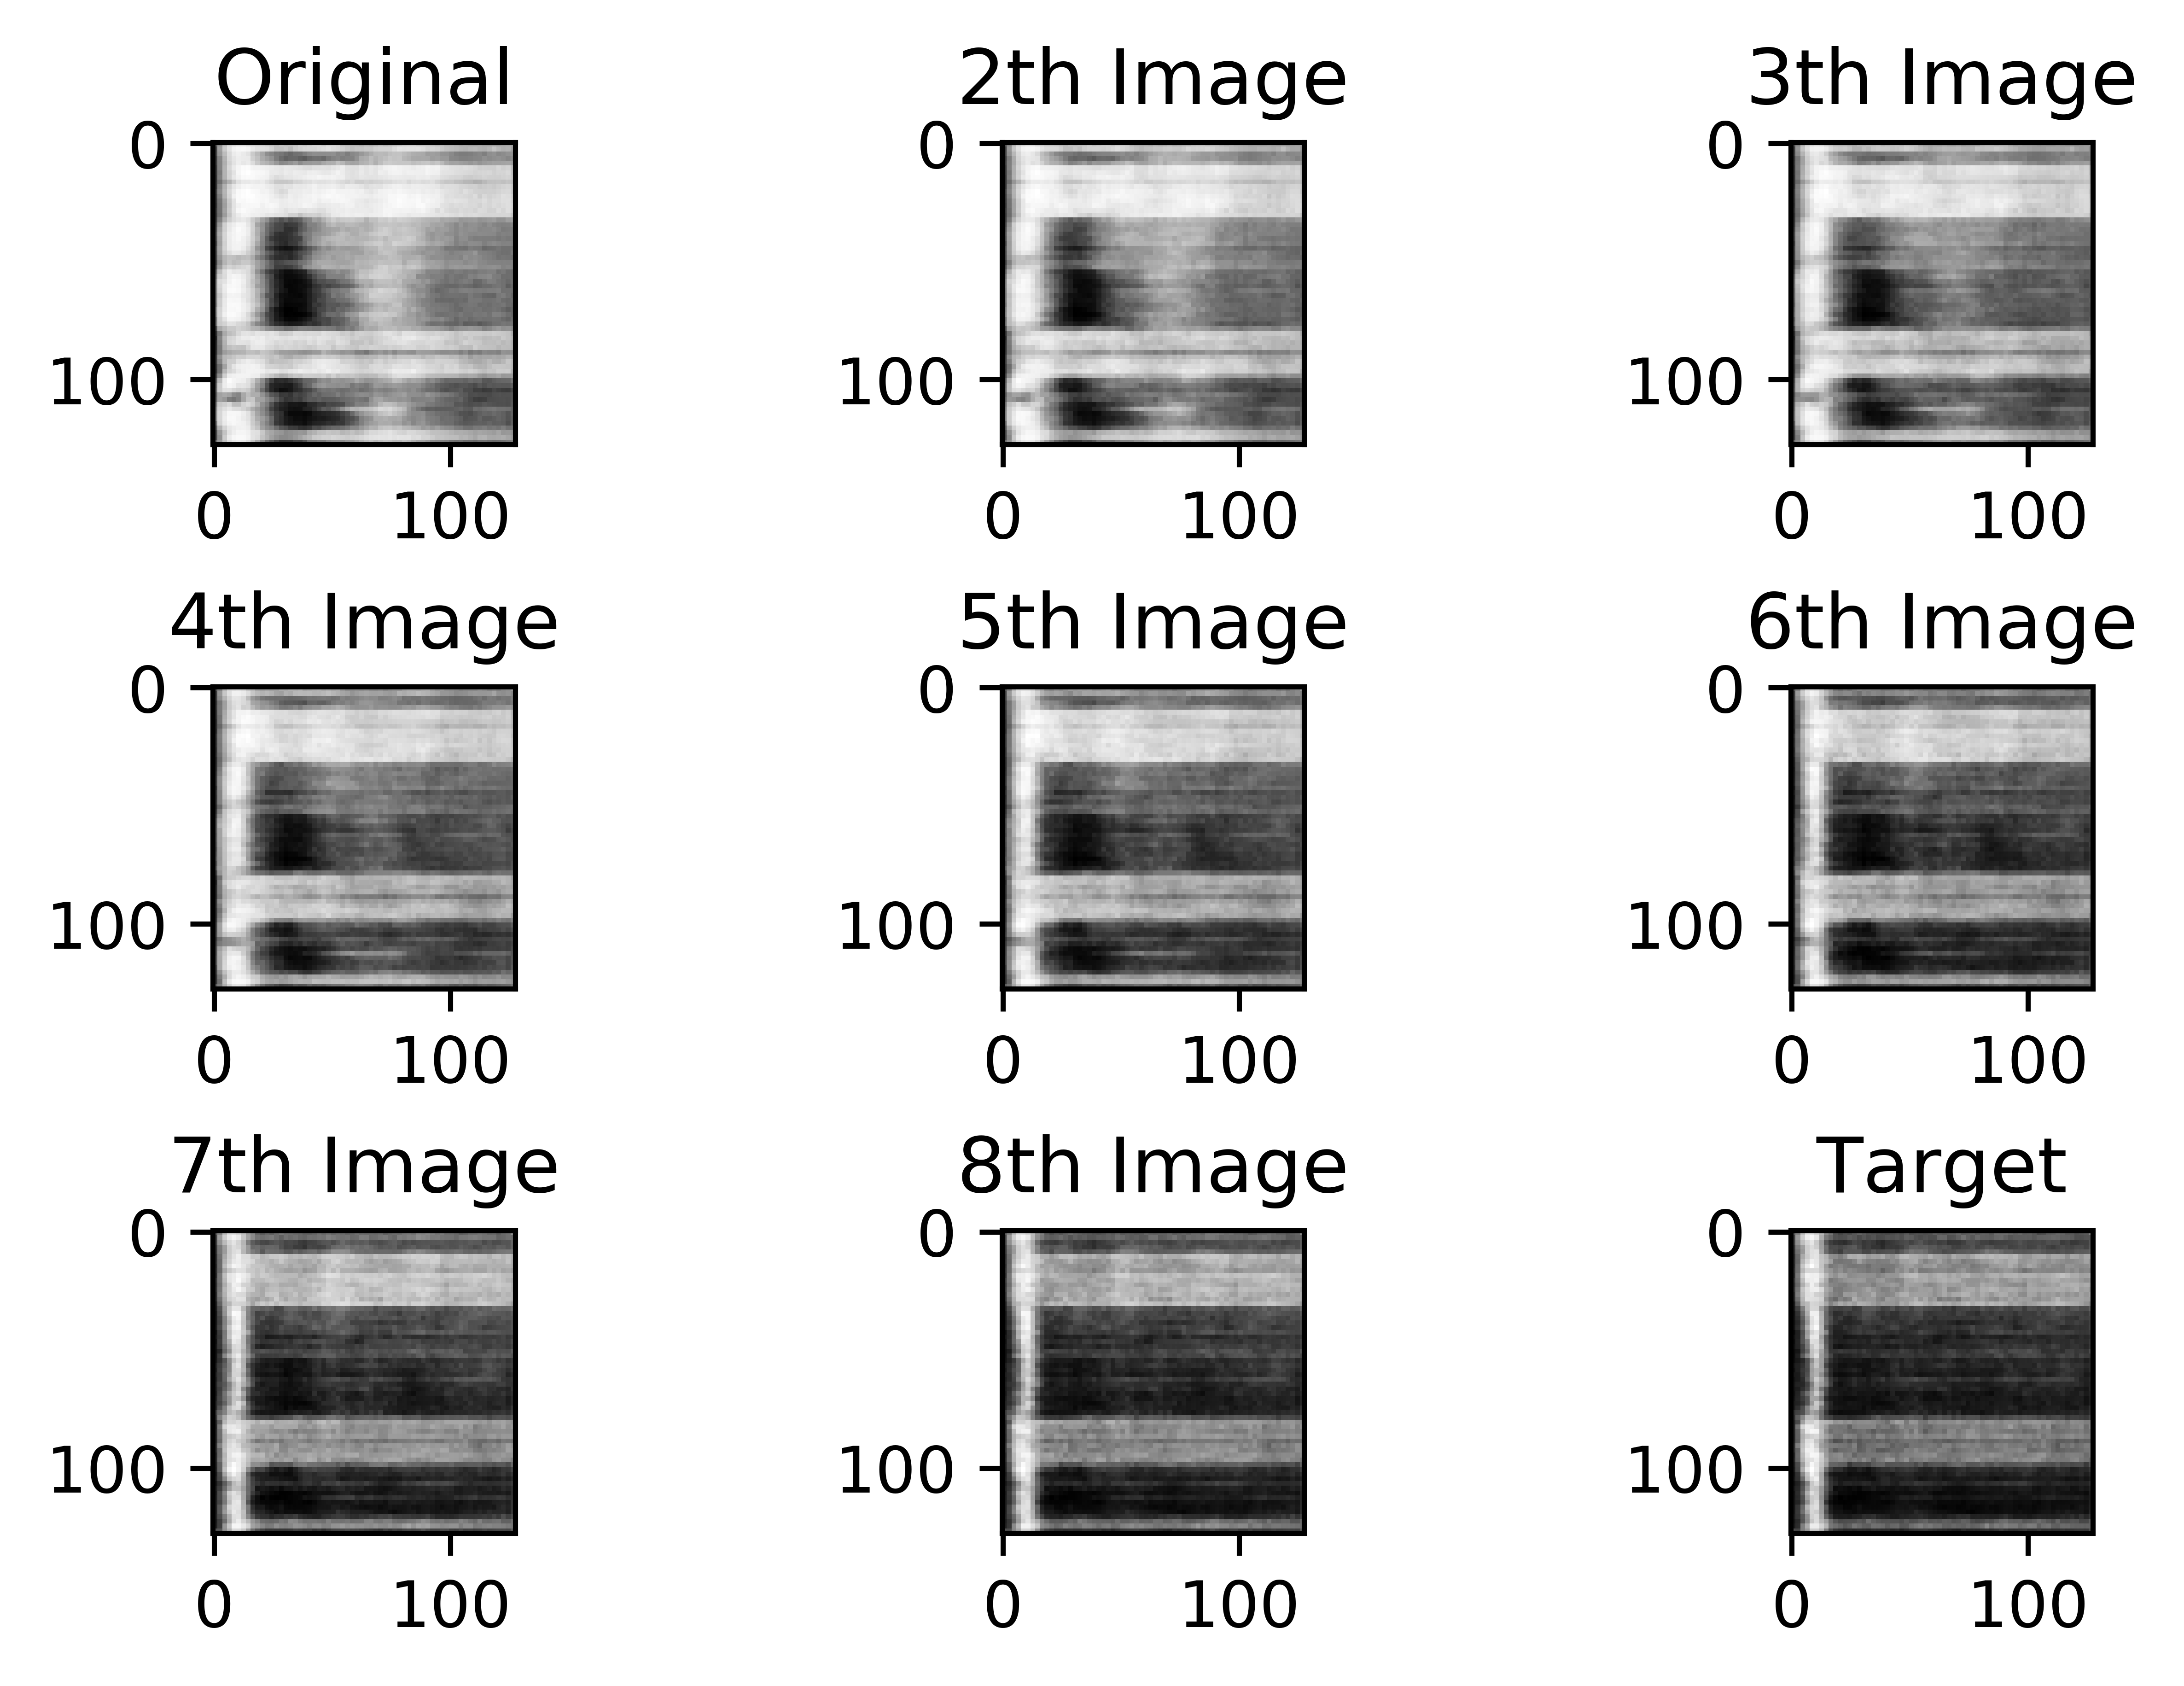

In [54]:
fig = plt.figure(dpi=1000)
subplots_adjust(hspace=0.8, wspace=0.4)
subfig = fig.add_subplot(3, 3, 1)
subfig.set_title("Original")
subfig.imshow(interpolation_reconstruct[0,0,...],cmap="gray")
for i in range(1,8):
    subfig = fig.add_subplot(3, 3, i+1)
    subfig.set_title("{}th Image".format(i+1))
    subfig.imshow(interpolation_reconstruct[i,0,...],cmap="gray")
subfig = fig.add_subplot(3, 3, 9)
subfig.set_title("Target")
subfig.imshow(interpolation_reconstruct[8,0,...],cmap="gray")